# DiD by Phase: Separate Estimates for Each Frequent Network Phase

The pooled DiD in notebooks 01/03 treats all phases as a single treatment. This is problematic because:
- Phase 1 has ~8 months of post-data, Phase 3 has ~2 months, Phase 4 has none
- Mixing treatment timing biases the estimate (already-treated routes shouldn't be controls)

This notebook runs a **separate 2x2 DiD for each phase**, using only never-treated routes as controls and excluding routes treated in earlier phases from the control pool.

| Phase | Launch Date | Routes | Post-data |
|-------|------------|--------|----------|
| 1 | Mar 23, 2025 | J14, 34, 47, 54, 60, 63, 79, 95 | ~8 months |
| 2 | Jun 15, 2025 | 4, 49, 53, 66 | ~5 months |
| 3 | Sep 15, 2025 | 20, 55, 77, 82 | ~2 months |
| 4 | Dec 21, 2025 | 9, 12, 72, 81 | NONE — skipped |

In [1]:
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from bus_check.config import ALL_FREQUENT_ROUTES, FREQUENT_NETWORK_PHASES
from bus_check.analysis.ridership_analysis import (
    prepare_did_data,
    select_control_routes,
)
from bus_check.data.ridership import fetch_all_routes

sns.set_theme(style="whitegrid")
PHASE_COLORS = {1: "#1b9e77", 2: "#d95f02", 3: "#7570b3", 4: "#e7298a"}

In [2]:
# Fetch all-route ridership
today_str = date.today().isoformat()
df_all = fetch_all_routes(start_date="2023-01-01", end_date=today_str)
print(f"Shape: {df_all.shape}, Date range: {df_all['date'].min().date()} to {df_all['date'].max().date()}")

Shape: (122084, 4), Date range: 2023-01-01 to 2025-11-30


In [3]:
# Phase-level DiD: separate estimate for each phase
results = []
phase_details = {}  # store full DiD data for event study plots

for phase in FREQUENT_NETWORK_PHASES:
    if phase.phase == 4:
        # No post-data for Phase 4
        results.append({
            "Phase": phase.phase, "Launch": phase.launch_date,
            "Treated": len(phase.routes), "Controls": 0,
            "Treated Pre": None, "Treated Post": None,
            "Control Pre": None, "Control Post": None,
            "DiD (rides/day)": None, "DiD (%)": None,
        })
        continue

    treated = phase.routes

    # Exclude all routes from earlier phases from the control pool
    earlier_treated = []
    for p in FREQUENT_NETWORK_PHASES:
        if p.phase < phase.phase:
            earlier_treated.extend(p.routes)

    # select_control_routes excludes all routes in treated_routes arg
    excluded = treated + earlier_treated
    controls = select_control_routes(df_all, excluded, n_controls=15)

    # Build phase_dates for this phase only
    phase_dates = {r: phase.launch_date for r in treated}

    df_did = prepare_did_data(df_all, treated, controls, phase_dates)
    did_wd = df_did[df_did["daytype"] == "W"]

    # 2x2 means
    gm = did_wd.groupby(["treated", "post"])["rides"].mean()
    tp = gm.get((True, True), 0)
    tr = gm.get((True, False), 0)
    cp = gm.get((False, True), 0)
    cr = gm.get((False, False), 0)

    did_est = (tp - tr) - (cp - cr)
    did_pct = did_est / tr * 100 if tr != 0 else 0

    results.append({
        "Phase": phase.phase, "Launch": phase.launch_date,
        "Treated": len(treated), "Controls": len(controls),
        "Treated Pre": f"{tr:,.0f}", "Treated Post": f"{tp:,.0f}",
        "Control Pre": f"{cr:,.0f}", "Control Post": f"{cp:,.0f}",
        "DiD (rides/day)": f"{did_est:+,.0f}",
        "DiD (%)": f"{did_pct:+.1f}%",
    })

    phase_details[phase.phase] = {
        "did_df": did_wd, "launch": phase.launch_date,
        "did_est": did_est, "did_pct": did_pct,
    }

    print(f"Phase {phase.phase}: DiD = {did_est:+,.0f} rides/day ({did_pct:+.1f}%), "
          f"{len(treated)} treated, {len(controls)} controls")

results_df = pd.DataFrame(results)
results_df

Phase 1: DiD = +428 rides/day (+5.9%), 8 treated, 15 controls


Phase 2: DiD = +514 rides/day (+4.2%), 4 treated, 15 controls


Phase 3: DiD = +1,142 rides/day (+10.4%), 4 treated, 15 controls


,Phase,Launch,Treated,Controls,Treated Pre,Treated Post,Control Pre,Control Post,DiD (rides/day),DiD (%)
0,1,2025-03-23,8,15,"7,292","8,454","7,298","8,032",+428,+5.9%
1,2,2025-06-15,4,15,"12,247","13,452","8,602","9,293",+514,+4.2%
2,3,2025-08-17,4,15,"10,926","12,979","8,635","9,547","+1,142",+10.4%
3,4,2025-12-21,4,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Bootstrap confidence intervals for each phase
np.random.seed(42)
N_BOOT = 1000

boot_results = []
for phase_num, detail in phase_details.items():
    did_wd = detail["did_df"]
    routes = did_wd["route"].unique()
    boot_estimates = []

    for _ in range(N_BOOT):
        # Resample routes (cluster bootstrap)
        boot_routes = np.random.choice(routes, size=len(routes), replace=True)
        boot_df = pd.concat([did_wd[did_wd["route"] == r] for r in boot_routes], ignore_index=True)

        gm = boot_df.groupby(["treated", "post"])["rides"].mean()
        tp = gm.get((True, True), 0)
        tr = gm.get((True, False), 0)
        cp = gm.get((False, True), 0)
        cr = gm.get((False, False), 0)
        boot_estimates.append((tp - tr) - (cp - cr))

    ci_lo, ci_hi = np.percentile(boot_estimates, [2.5, 97.5])
    boot_results.append({
        "phase": phase_num,
        "did": detail["did_est"],
        "ci_lo": ci_lo,
        "ci_hi": ci_hi,
    })
    print(f"Phase {phase_num}: DiD = {detail['did_est']:+,.0f} [{ci_lo:+,.0f}, {ci_hi:+,.0f}]")

boot_df = pd.DataFrame(boot_results)

Phase 1: DiD = +428 [+42, +799]


Phase 2: DiD = +514 [+163, +832]


Phase 3: DiD = +1,142 [+213, +2,492]


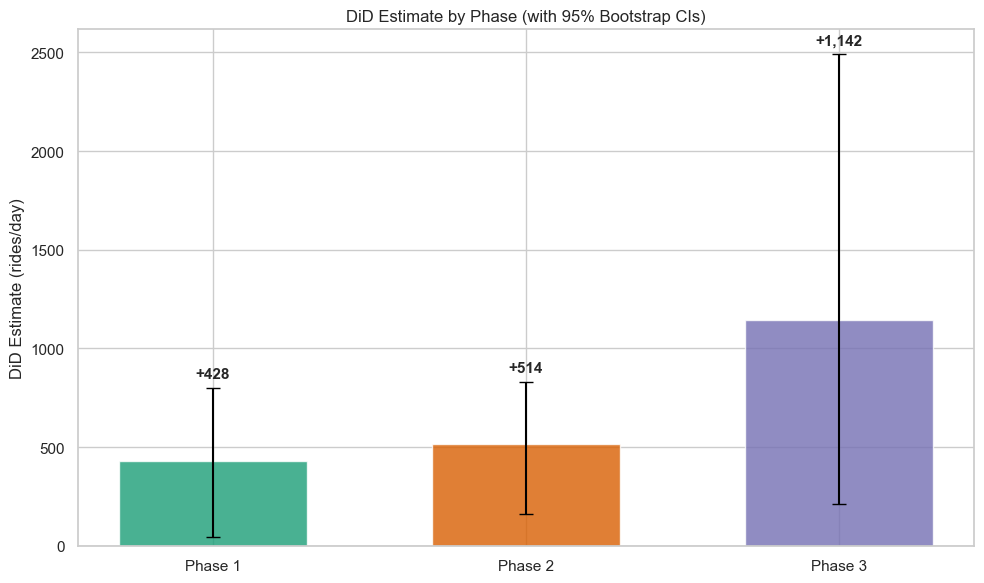

In [5]:
# Bar chart with bootstrap CIs
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(boot_df))
colors = [PHASE_COLORS[p] for p in boot_df["phase"]]
bars = ax.bar(x, boot_df["did"], color=colors, alpha=0.8, width=0.6)

# Error bars
yerr_lo = boot_df["did"] - boot_df["ci_lo"]
yerr_hi = boot_df["ci_hi"] - boot_df["did"]
ax.errorbar(x, boot_df["did"], yerr=[yerr_lo, yerr_hi],
            fmt="none", ecolor="black", capsize=5, linewidth=1.5)

ax.axhline(0, color="gray", linestyle="-", linewidth=0.8)
ax.set_xticks(x)
ax.set_xticklabels([f"Phase {p}" for p in boot_df["phase"]])
ax.set_ylabel("DiD Estimate (rides/day)")
ax.set_title("DiD Estimate by Phase (with 95% Bootstrap CIs)")

for i, row in boot_df.iterrows():
    ax.text(i, row["did"] + (row["ci_hi"] - row["did"]) + 50,
            f"{row['did']:+,.0f}", ha="center", fontweight="bold", fontsize=11)

plt.tight_layout()
plt.show()

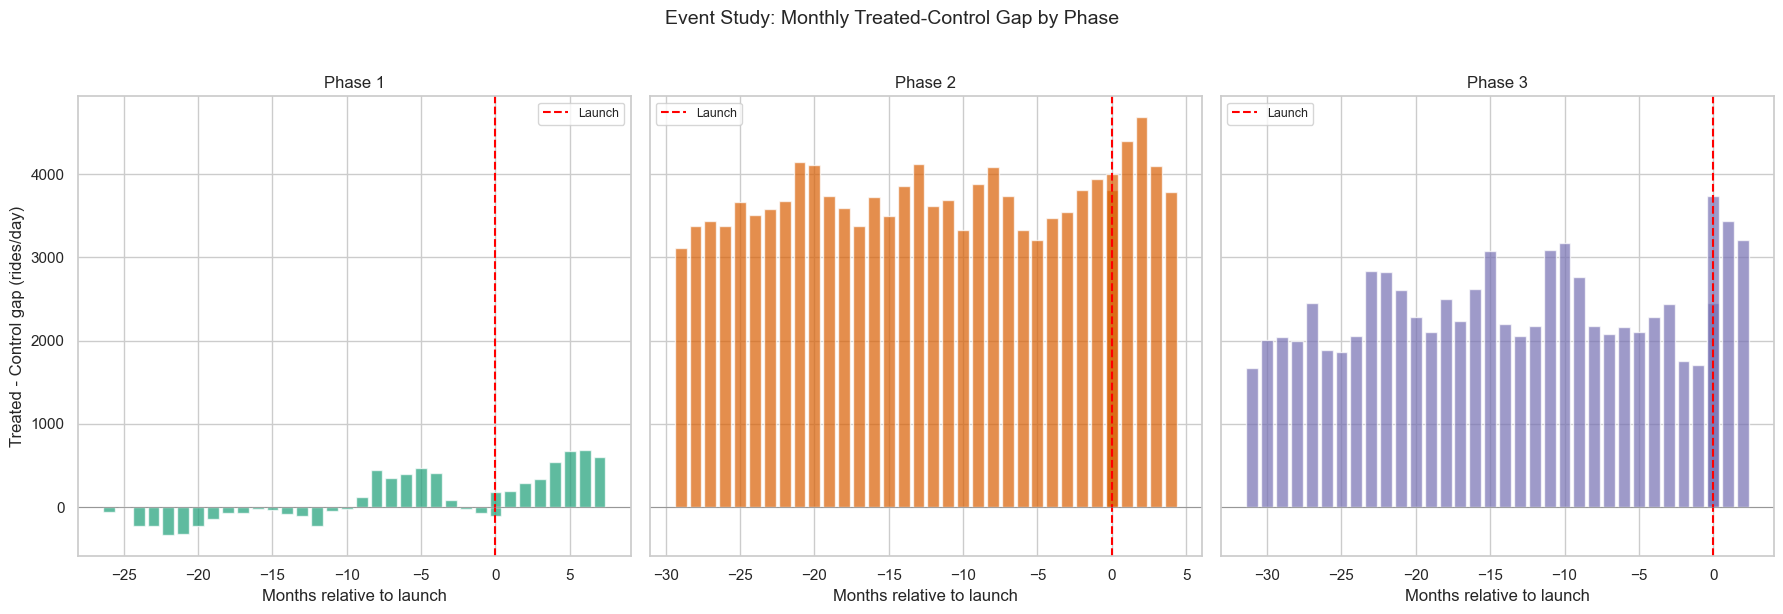

In [6]:
# Event study: monthly treated-vs-control gap relative to launch
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, (phase_num, detail) in enumerate(phase_details.items()):
    ax = axes[idx]
    did_wd = detail["did_df"]
    launch = pd.Timestamp(detail["launch"])

    # Monthly averages by treated/control
    did_wd = did_wd.copy()
    did_wd["month"] = did_wd["date"].dt.to_period("M").dt.to_timestamp()
    monthly = did_wd.groupby(["month", "treated"])["rides"].mean().unstack("treated")

    if True in monthly.columns and False in monthly.columns:
        monthly["gap"] = monthly[True] - monthly[False]

        # Event time (months relative to launch)
        monthly["event_month"] = ((monthly.index - launch) / pd.Timedelta(days=30.44)).astype(int)

        ax.bar(monthly["event_month"], monthly["gap"],
               color=PHASE_COLORS[phase_num], alpha=0.7, width=0.8)
        ax.axvline(0, color="red", linestyle="--", linewidth=1.5, label="Launch")
        ax.axhline(0, color="gray", linestyle="-", linewidth=0.5)

    ax.set_title(f"Phase {phase_num}")
    ax.set_xlabel("Months relative to launch")
    if idx == 0:
        ax.set_ylabel("Treated - Control gap (rides/day)")
    ax.legend(fontsize=9)

fig.suptitle("Event Study: Monthly Treated-Control Gap by Phase", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Summary

Breaking DiD by phase reveals whether the pooled negative estimate (-4.6%) is driven by specific phases or is uniform.

**Key design choices:**
- Each phase uses only its own routes as treated
- Control pool excludes routes treated in any earlier phase
- Phase 4 is skipped (no post-data)
- Bootstrap CIs are clustered at the route level

**Limitations:**
- Phase 3 has only ~2 months of post-data (low power)
- Phase 2/3 launch dates are approximate
- Control route selection may still introduce bias (matching on pre-treatment mean only)